## Setup

In [1]:
import os, sys, imio, tifffile
from skimage.io import imread, imread_collection, concatenate_images
import skimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy import ndimage
from matplotlib import colors
from tqdm import tqdm
from brainglobe_utils.brainreg import transform
from bg_atlasapi.bg_atlas import BrainGlobeAtlas

In [2]:
# include the raw image stack channels and the cellfinder output file in the NAME directory
NAME = 'SC004'
channel_signal_name = 'r'
channel_background_name = 'g'
network_nickname = 'bt14'
binary_thresh = np.sqrt(1000)
med_filter_iters = 3
atlas = BrainGlobeAtlas('allen_mouse_10um')

In [3]:
def open_binarised_coordinates(name):
    path = f'braintracer/fluorescence/binary_{name}.npy'
    assert os.path.isfile(path), f'Please provide binarised stack coordinates at {path}'
    coordinates = np.load(path)
    return coordinates

## Filter and binarise image stack

In [4]:
stack1 = imread_collection(f'{NAME}/{channel_signal_name}/*.tif')
stack2 = imread_collection(f'{NAME}/{channel_background_name}/*.tif')
len(stack1), len(stack2)

(2880, 2880)

In [5]:
foreg = imread(f'braintracer/downsampled_data/reg_{NAME}_{channel_signal_name}.tiff')
backg = imread(f'braintracer/downsampled_data/reg_{NAME}_{channel_background_name}.tiff')
foreg.shape, backg.shape

((1320, 800, 1140), (1320, 800, 1140))

In [6]:
def fit_model(model, y, x, name, ax=None):
    X = np.array(x).reshape(len(x),1)
    line_X = np.arange(min(x), max(x))[:, np.newaxis]
    model.fit(X, y)
    line_y = model.predict(line_X)
    try:
        if ax != None:
            ax.plot(line_X, line_y, color='r', linewidth=1, label=name)
        return model.coef_, model.intercept_
    except Exception:
        if ax != None:
            ax.plot(line_X, line_y, color='m', linewidth=1, label=name)
        return model.estimator_.coef_, model.estimator_.intercept_

def get_subtraction_coeffs(ax):
    ref_vals = backg.flatten()[::10_000] # every 1000 values of the array
    sig_vals = foreg.flatten()[::10_000] # same coordinates chosen from both image stacks

    if ax != None:
        ax.hist2d(ref_vals, sig_vals, bins=500, cmap=plt.cm.jet, norm=colors.LogNorm())
        ax.set_ylim(0,7000)
        ax.set_xlim(0,2000)

    ransac = linear_model.RANSACRegressor(max_trials=30)
    m, c = fit_model(ransac, sig_vals, ref_vals, 'RANSAC', ax=ax)
    m = m[0] # extract from array
    return m, c

Subtraction parameters are: m=0.22102941627242254, c=0.1983435399286626


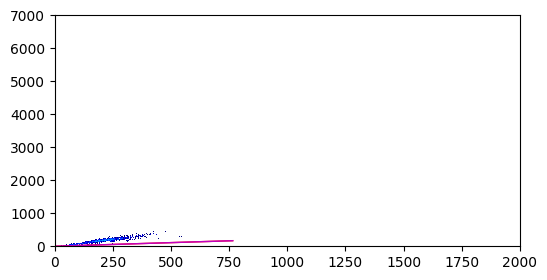

In [7]:
f, ax = plt.subplots(figsize=(6,3))
m, c = get_subtraction_coeffs(ax)
#plt.savefig(f'fit.png', dpi=600, bbox_inches='tight')
print(f'Subtraction parameters are: m={m}, c={c}')

In [8]:
all_x_idxs, all_y_idxs, all_z_idxs = [], [], []

In [9]:
for i in tqdm(range(len(stack1))):
    subtracted_im = stack1[i] - ((stack2[i] * m) + c)
    sqt_im = np.sqrt(subtracted_im)
    bin_im = np.where(sqt_im > binary_thresh, 1, 0)
    mfl_im = ndimage.median_filter(bin_im, med_filter_iters)
    x_idxs, y_idxs = np.where(mfl_im == 1)
    x_idxs, y_idxs = list(x_idxs), list(y_idxs) # convert from tuples to lists for addition to all_idxs lists
    z_idxs = list(np.repeat([i], len(x_idxs))) # generate the z coordinate for all the points in this slice
    all_x_idxs = all_x_idxs + x_idxs
    all_y_idxs = all_y_idxs + y_idxs
    all_z_idxs = all_z_idxs + z_idxs

  0%|                                                                                      | 0/2880 [00:00<?, ?it/s]C:\Users\Sam\AppData\Local\Temp\ipykernel_19076\3634472674.py:3: RuntimeWarning: invalid value encountered in sqrt
  sqt_im = np.sqrt(subtracted_im)
100%|███████████████████████████████████████████████████████████████████████████| 2880/2880 [42:11<00:00,  1.14it/s]


## Saving coordinates

In [10]:
all_coordinates = np.array([all_x_idxs, all_y_idxs, all_z_idxs])
all_coordinates

array([[1832, 1832, 1833, ..., 1449, 1449, 1450],
       [3194, 3195, 3194, ..., 3139, 3140, 3140],
       [   0,    0,    0, ..., 2878, 2878, 2878]], dtype=int64)

In [11]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_{NAME}_{channel_signal_name}'
np.save(dest, all_coordinates)

## Loading binarised coordinates

In [12]:
coordinates_yxz = open_binarised_coordinates(f'{NAME}_{channel_signal_name}') # checked values saved in array and looks like saved as yxz rather than xyz. Check above
coordinates = coordinates_yxz.T # y, x, z
coordinates = np.flip(coordinates, axis=1) # z, x, y

In [13]:
#f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
#ax1.hist(coordinates[:,0]); ax2.hist(coordinates[:,1]); ax3.hist(coordinates[:,2]);

## Transforming coordinates to downsampled space

In [15]:
signal_planes = f'{NAME}/{channel_signal_name}'
source_shape = tuple(imio.get_size_image_from_file_paths(signal_planes).values())
source_shape = (source_shape[2], source_shape[1], source_shape[0]) # z, y, x   # here z is shorter than x and y because resolution is 5 um
# should be downsampled_channel_0 but same resolution anyway?
dest_shape = imread(f'{NAME}/cellfinder_{channel_signal_name}_{network_nickname}/registration/downsampled_channel_0.tiff').shape # z, y, x
scalars = tuple(x / source_shape[i] for i, x in enumerate(dest_shape)) # (dest_shape / source_shape) as tuple
print(f'Source shape: {source_shape}, Destination shape: {dest_shape}, Calculated scalars: {scalars}') # z, y, x

Source shape: (2880, 3327, 5069), Destination shape: (1440, 665, 1014), Calculated scalars: (0.5, 0.19987977156597536, 0.20003945551390806)


In [16]:
coordinates[:,0] = np.round(coordinates[:,0] * scalars[0]) # downsample coordinates
coordinates[:,1] = np.round(coordinates[:,1] * scalars[1])
coordinates[:,2] = np.round(coordinates[:,2] * scalars[2])
coordinates[:,0] = dest_shape[0] - coordinates[:,0] # flip the z axis because that's what brainreg does to get psr
downsampled_points = coordinates # rename var ____ z, x, y

In [17]:
np.max(downsampled_points, axis=0)

array([1440, 1013,  664], dtype=int64)

In [18]:
#f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
#ax1.hist(downsampled_points[:,0]); ax2.hist(downsampled_points[:,1]); ax3.hist(downsampled_points[:,2]);

## Transforming coordinates to atlas space

In [19]:
def get_deformation_field_path(num):
    return f'{NAME}/cellfinder_{channel_signal_name}_{network_nickname}/registration/deformation_field_{num}.tiff'
deformation_field_paths = [get_deformation_field_path(0), get_deformation_field_path(1), get_deformation_field_path(2)]
# z, y, x because psr orientation

In [20]:
downsampled_points[:, 1], downsampled_points[:, 2] = downsampled_points[:, 2], downsampled_points[:, 1].copy()
# swap the x and y value of each coordinate to match the deformation fields

In [21]:
downsampled_points = downsampled_points[downsampled_points[:,0]<dest_shape[0]]
downsampled_points = downsampled_points[downsampled_points[:,1]<dest_shape[1]]
downsampled_points = downsampled_points[downsampled_points[:,2]<dest_shape[2]]
# remove the last slice of coordinates in each axis because not in the deformation matrices

In [22]:
#f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
#ax1.hist(downsampled_points[:,0]); ax2.hist(downsampled_points[:,1]); ax3.hist(downsampled_points[:,2]);

In [23]:
transformed_cells = transform.transform_points_from_downsampled_to_atlas_space( # z, y, x coordinates and 0, 1, 2 deformation fields
            downsampled_points,
            atlas,
            deformation_field_paths)

In [24]:
#f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
#ax1.hist(transformed_cells[:,0]); ax2.hist(transformed_cells[:,1]); ax3.hist(transformed_cells[:,2]);
#atlas_z, atlas_y, atlas_x = atlas.shape # z, y, x
#ax1.set_xlim(0,atlas_x); ax2.set_xlim(0,atlas_y); ax3.set_xlim(0,atlas_z);

In [27]:
tc = transformed_cells[0]
tc = tc[np.logical_and.reduce((tc[:,0] < atlas.shape[0], tc[:,1] < atlas.shape[1], tc[:,2] < atlas.shape[2]))]
# trim the transformed coordinates within the shape of the atlas

In [28]:
np.max(tc, axis=0) # z, y, x

array([1319,  799, 1109])

## Save coordinates for use in braintracer downstream functions

In [29]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_registered_{NAME}_{channel_signal_name}'
np.save(dest, tc)

In [27]:
#tc = open_binarised_coordinates(f'registered_{NAME}') # for starting from this point

## Save version without a bulk of labelling from injection site to save memory

In [28]:
from braintracer.braintracer.analysis import _get_area_index
from braintracer.braintracer.analysis import children_from
tc = open_binarised_coordinates(f'registered_{NAME}_{channel_signal_name}') # use if already saved using the function above

In [37]:
parent, children = children_from(528, depth=0)
areas = [parent] + children

In [38]:
tc = list(filter(lambda c: _get_area_index(*c) not in areas, tc))

In [39]:
tc = np.array(tc)

In [40]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
dest = dir_path + f'binary_registered_skimmed_{NAME}_{channel_signal_name}'
np.save(dest, tc)

## Save downsampled binarised stack for use in braintracer downstream functions

In [30]:
NAME='SC004'

In [31]:
skimmed = False

In [32]:
if skimmed:
    tc = open_binarised_coordinates(f'registered_skimmed_{NAME}_{channel_signal_name}')
else:
    tc = open_binarised_coordinates(f'registered_{NAME}_{channel_signal_name}')

In [33]:
atlas_space = np.zeros((1320, 800, 1140))
for pt in tc:
    try:
        atlas_space[tuple(pt)] = 1 #print(f'coordinate was in bounds. coord = {coord}, val = {val}')
    except (IndexError) as e: #print(f'Index {z, y, x} was out of bounds.')
        pass

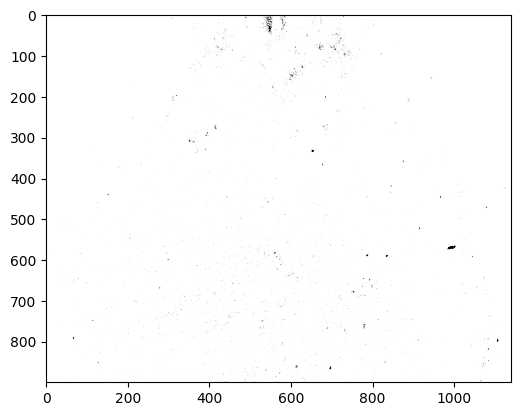

In [34]:
f, ax1 = plt.subplots(figsize=(6,6))
ax1.imshow(np.sum(atlas_space, axis=1)[:900,:], cmap='Greys', vmax=2)
plt.savefig(f"{NAME}_binarised_summary_skimmed.pdf", dpi=600, format="pdf")

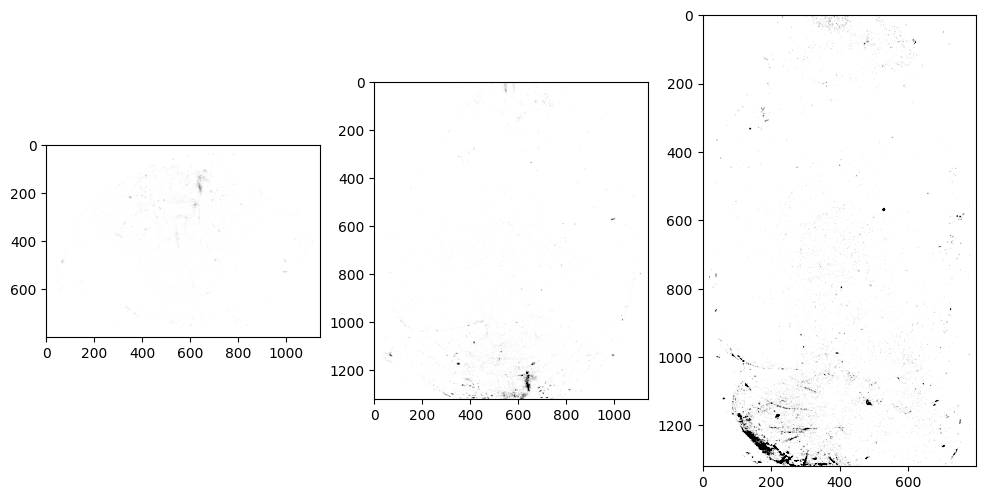

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.imshow(np.sum(atlas_space, axis=0), cmap='Greys', vmax=10) # norm='log'
ax2.imshow(np.sum(atlas_space, axis=1), cmap='Greys', vmax=4)
ax3.imshow(np.sum(atlas_space, axis=2), cmap='Greys', vmax=2)
plt.savefig(f"{NAME}_binarised_summary.pdf", dpi=600, format="pdf")

In [36]:
dir_path = 'braintracer/fluorescence/'
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
if skimmed:
    dest = dir_path + f'binary_registered_stack_skimmed_{NAME}_{channel_signal_name}'
else:
    dest = dir_path + f'binary_registered_stack_{NAME}_{channel_signal_name}'
np.save(dest, atlas_space)

## Save as tiff

In [ ]:
skimage.io.imsave(f'previous_{NAME}.tiff', atlas_space)

C:\Users\Sam\AppData\Local\Temp\ipykernel_19076\215882661.py:1: UserWarning: previous_SC004.tiff is a low contrast image
  skimage.io.imsave(f'previous_{NAME}.tiff', atlas_space)
